In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('Data/data 258.csv')

# convert integers to float so I don't have to see warnings anymore
data.loc[:, 'TUITION2'] = data.TUITION2.astype('float64')
data.loc[:, 'avg_award'] = data.avg_award.astype('float64')
data.head()

,UNITID,EFFYLEV,LSTUDY,XEYTOTLT,EFYTOTLT,XEYTOTLM,EFYTOTLM,XEYTOTLW,EFYTOTLW,XEFYAIAT,...,diverse_ind_std,annual_cost_std,avg_award_sqrt_std,pct_awarded_sqrt_std,GRNRALT_rate_std,logit_intl_pct,TUITION2_std,avg_award_std,pct_awarded_std,logit
0,107044,2,1,R,4789,R,2101,R,2688,R,...,-1.726940,-2.352586,0.010589,1.210253,-0.093704,-2.646689,-1.623191,-0.317656,1.965755,-2.646689
1,109785,2,1,R,6263,R,2141,R,4122,R,...,1.549113,-0.051556,-0.735559,-1.160270,-0.735287,-3.654268,-0.167906,-0.870936,-0.899768,-3.654268
2,110413,2,1,R,3207,R,1392,R,1815,R,...,1.108905,-0.150939,0.292282,0.313240,0.722638,-3.264918,0.147635,-0.021935,0.207421,-3.264918
3,110510,2,1,R,19244,R,7694,R,11550,R,...,0.076189,-2.319545,-0.648466,-1.160270,0.196608,-2.549053,-2.656479,-0.823571,-0.899768,-2.549053
4,111081,2,1,R,991,R,421,R,570,R,...,1.274542,0.564100,-1.598646,-1.160270,0.446135,-1.662439,0.622462,-1.094357,-0.899768,-1.662439


In [3]:
# change all proportions to percentages
#data.loc[:, 'GRNRALT_rate'] = data.GRNRALT_rate*100
#data.loc[:, 'diverse_ind'] = data.diverse_ind*100
#data.loc[:, 'pct_awarded'] = data.pct_awarded*100

In [5]:
#data.to_csv('Data/data 258.csv', index = False)

In [3]:
features = ['GRNRALT_rate','TUITION2','diverse_ind','avg_award','pct_awarded']
features_std = []
for i in range(len(features)):
    features_std.append(features[i]+'_std')

In [4]:
#data.to_csv('Data/data 258.csv', index = False)
from sklearn.model_selection import train_test_split
np.random.seed(951)
train, test = train_test_split(data, test_size = 0.2)
train.shape
test.shape

(52, 558)

In [27]:
# current final model
# standardize
scaler = StandardScaler()
scaler.fit(train[features])
transformed_linear = LinearRegression()
result = transformed_linear.fit(X = scaler.transform(train[features]), y = train.logit)
y_pred_logit = result.predict(X = scaler.transform(test[features]))
result.coef_

array([ 0.29212099,  0.27136619,  0.23696898,  0.09147241, -0.04355403])

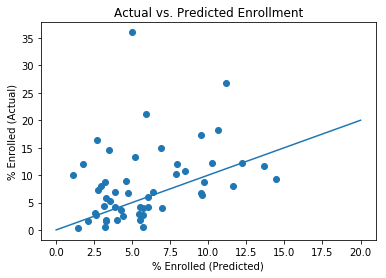

In [20]:
y_pred = reverse_logit(y_pred_logit)
plt.scatter(y_pred*100, test.intl_pct)
plt.title('Actual vs. Predicted Enrollment')
plt.xlabel('% Enrolled (Predicted)')
plt.ylabel('% Enrolled (Actual)')
plt.plot([0,20],[0,20])

In [18]:
# mean absolute error
np.mean(np.abs(y_pred*100- test.intl_pct)) #4.45%

4.451004146671471

In [90]:
# how do I suggest actionable insight?
# exclude tuition
# strategy: suggest the one with the biggest return on investment, if move up in the distribution by 10th percentile
# exception: graduation rate above median
# take one school
value = '111948'
inst_value = data[data.UNITID==value][features]
feature = features[1]
#print(inst_value[feature].values[0])
percent = np.mean(data[feature]<=inst_value[feature].values[0])
print(feature, percent)
new_percent = np.min([percent + 0.1, 1])
print(new_percent)
new_inst_value = np.percentile(data[feature], new_percent)
print(new_inst_value)


TUITION2 0.3372093023255814
0.4372093023255814
4432.700093023256


In [39]:
feature = features[3]
np.min(data[data[feature]>0][feature])

1700.0

0.5038759689922481

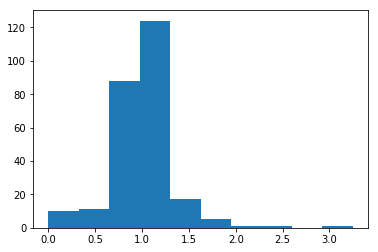

In [16]:
# look at international vs overall graduation rate
plt.hist(data.GRNRALT_rate/data.GRTOTLT_rate)
sum(data.GRNRALT_rate/data.GRTOTLT_rate<1)/258 # half schools have international graduation rate below 

# everything put together

In [11]:
# fit the model
scaler = StandardScaler()
scaler.fit(data[features])
transformed_linear = LinearRegression()
result = transformed_linear.fit(X = scaler.transform(data[features]), y = data.logit)

In [8]:
def get_percentile(feature, inst_value, data, extra_pct = 0.1):
    """
    don't put in 0 as extra_pct, don't work
    """
    feature_value = inst_value[feature].values[0]
    percent = np.mean(data[feature]< feature_value)
    new_percent = np.min([percent + extra_pct, 1])
    new_feature_value = np.percentile(data[feature], new_percent*100)
    # if new feature value is 0 (in the case of financial aid)
    if new_feature_value == 0:
        new_feature_value = np.min(data[data[feature]>0][feature])
        new_percent = np.mean(data[feature]< new_feature_value)
    return {'feature_value':feature_value, 
            'percent':percent, 
            'new_feature_value':new_feature_value, 
            'new_percent':new_percent}
def reverse_logit(logit):
    return np.exp(logit)/(1 + np.exp(logit))
def get_improvement(feature, inst_value, data, result, scaler, extra_pct = 0.1):
    input_update = get_percentile(feature, inst_value, data, extra_pct)
    old_prediction = result.predict(X = scaler.transform(inst_value))
    old_intl_pct = reverse_logit(old_prediction[0])
    new_inst_value = inst_value.copy()
    new_inst_value[feature] = input_update['new_feature_value']
    new_prediction = result.predict(X = scaler.transform(new_inst_value))
    new_intl_pct = reverse_logit(new_prediction[0])
    increase = (new_intl_pct - old_intl_pct)*100
    return round(np.min([increase, 100]),2)
def select_best_feature(value, features_actionable, inst_value, data, result, scaler, extra_pct = 0.1):
    improvements = {}
    for feature in features_actionable:
        improvements[feature] = get_improvement(feature, inst_value, data, result, scaler, extra_pct)
    best_feature = max(improvements, key = improvements.get)
    return([best_feature, improvements])

def generate_recommendations(best_feature, value, inst_value, data, extra_pct = 0.1):
    if best_feature[0] == 'GRNRALT_rate':
        update = get_percentile('GRNRALT_rate', inst_value, data, extra_pct)
        string = "Currently, your international student graduation rate is {}%, better than {}% of the institutions. As a reference, your overall graduation rate is {}%. If you boost your international graduation rate to {}% (better than {}% of the institutions), you should attract an additional {}% of international students."
        output_text = html.Div([
                html.P(
                string.format( 
                        str(round(update['feature_value']*100,1)), 
                        str(round(update['percent']*100,1)),
                        str(round(data.GRTOTLT_rate[data.UNITID==value].values[0]*100,1)),
                        str(round(update['new_feature_value']*100,1)),
                        str(round(update['new_percent']*100,1)),
                        str(best_feature[1]['GRNRALT_rate'])
                   )
                ),
                html.P('Additional resource: '),
                dcc.Link('https://www.nafsa.org/professional-resources/publications/retaining-international-students', 
                         href='https://www.nafsa.org/professional-resources/publications/retaining-international-students')]
    )
        #output_graph = make_bar(data[data.UNITID == value])
        return output_text# output_graph#,
    if best_feature[0] == 'diverse_ind':
        update = get_percentile(best_feature[0], inst_value, data, extra_pct = 0.1)
        string = "Currently, your racial diversity index is {}%, better than {}% of the institutions. (*Also show a distribution of races.) If you recruit more domestic students of racial minorities, and boost your diversity index to {}% (better than {}% of the institutions), you should attract an additional {}% of international students."
        output_text = string.format( 
            str(round(update['feature_value']*100,1)), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value']*100,1)),
            str(round(update['new_percent']*100,1)),
            str(best_feature[1][best_feature[0]])
                   )
        #output_graph = make_bar(data[data.UNITID == value])
        return  output_text# output_graph#,
    if best_feature[0] == 'avg_award': 
        update = get_percentile(best_feature[0], inst_value, data, extra_pct = 0.1)
        string = "Currently, your average international student receives ${} in financial aid, better than {}% of the institutions. If you increase your average financial aid to ${} (better than {}% of the institutions), you should attract an additional {}% of international students."
        output = string.format( 
            str(round(update['feature_value'])), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value'])),
            str(round(update['new_percent']*100,1)),
            str(best_feature[1][best_feature[0]])
                   )
        return output
    if best_feature[0] == 'pct_awarded': 
        update = get_percentile(best_feature[0], inst_value, data, extra_pct = 0.1)
        string = "Currently, {}% of your international students receive financial aid, better than {}% of the institutions. If you award financial aid to {}% of the international students (better than {}% of the institutions), you should attract an additional {}% of international students."
        output = string.format( 
            str(round(update['feature_value']*100,1)), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value']*100,1)),
            str(round(update['new_percent']*100,1)),
            str(best_feature[1][best_feature[0]])
                   )
        return output

In [9]:
def update_recommendation(value, features_actionable, data, extra_pct = 0.1):
    inst_value = data[data.UNITID==value][features] # all features used in the model
    # fit the model
    scaler = StandardScaler()
    scaler.fit(data[features])
    transformed_linear = LinearRegression()
    result = transformed_linear.fit(X = scaler.transform(data[features]), y = data.logit)
    best_feature = select_best_feature(value, features_actionable, inst_value, data, result, scaler, extra_pct)
    recommendations = generate_recommendations(best_feature, inst_value, data, extra_pct)
    return recommendations

In [9]:
features_actionable = ['GRNRALT_rate','diverse_ind','avg_award','pct_awarded']
value = data.UNITID[5]
update_recommendation(value, features_actionable, data)

NameError: name 'update_recommendation' is not defined

In [46]:
def update_snapshot(value):
    output = 'Your instituion snapshot:'
    for i in range(len(features)):
        newline = feature_display_name[i] + ':' + str(data[data.UNITID == value][features[i]].values[0])
        output = output + newline
    return output

In [48]:
feature_display_name = [
                        'International Graduation Rate',
                        'Tuition', 
                        'Diversity Index',
                        'Financial Aid $',
                        'Financial Aid %'
                        ]
update_snapshot(value)

'Your instituion snapshot:International Graduation Rate:0.7560975609999999Tuition:50210.0Diversity Index:0.571064856Financial Aid $:0.0Financial Aid %:0.0'

# race histogram

In [ ]:
import plotly.graph_objs as go
go.Bar?

In [6]:
features_actionable = ['GRNRALT_rate','diverse_ind','avg_award','pct_awarded']
features_actionable[:2]

['GRNRALT_rate', 'diverse_ind']

In [97]:
#data.GRTOTLT_rate

['GRNRALT_rate', 'TUITION2']

# How much money will they make?

In [6]:
# model with everybody
scaler = StandardScaler()
scaler.fit(data[features])
transformed_linear = LinearRegression()
result = transformed_linear.fit(X = scaler.transform(data[features]), y = data.logit)
y_pred_logit = result.predict(X = scaler.transform(data[features]))
result.coef_

array([0.27159511, 0.23671089, 0.23144125, 0.08441141, 0.02364637])

In [43]:
# function calls def get_improvement
value = data.UNITID[10]
feature = features[3]
inst_value = data[data.UNITID==value][features]
print(inst_value)
update = get_percentile(feature, inst_value, data)
imp = get_improvement(feature, inst_value, data, result, scaler)

    GRNRALT_rate  TUITION2  diverse_ind  avg_award  pct_awarded
10     71.428571   52260.0    65.933243    31399.0     3.100775


In [45]:
features[3]

'avg_award'

In [44]:
student_gain = data['EFYTOTLT'][data.UNITID==value]*imp/100
tuition_gain = student_gain * data['TUITION2'][data.UNITID==value]
print(tuition_gain)
scholarship_pay = data['EFYNRALT'][data.UNITID==value] * (update['new_feature_value']- update['feature_value'])
print(scholarship_pay)

net_gain = tuition_gain - scholarship_pay

10    1042911.012
dtype: float64
10    1947132.0
Name: EFYNRALT, dtype: float64


In [10]:
def net_gain_avg_aid(value, data, result, scaler, extra_pct = 0.1):
    inst_value = data[data.UNITID==value][features]
    update = get_percentile('avg_award', inst_value, data, extra_pct)
    imp = get_improvement('avg_award', inst_value, data, result, scaler, extra_pct)
    student_gain = data['EFYTOTLT'][data.UNITID==value]*imp/100
    tuition_gain = student_gain * data['TUITION2'][data.UNITID==value]
    scholarship_pay = data['EFYNRALT'][data.UNITID==value] * (update['new_feature_value']- update['feature_value'])
    net_gain = tuition_gain - scholarship_pay
    return net_gain.values[0]

def net_gain_pct_aid(value, data, result, scaler, extra_pct = 0.1):
    inst_value = data[data.UNITID==value][features]
    update = get_percentile('pct_awarded', inst_value, data, extra_pct)
    imp = get_improvement('pct_awarded', inst_value, data, result, scaler, extra_pct)
    student_gain = data['EFYTOTLT'][data.UNITID==value]*imp/100
    tuition_gain = student_gain * data['TUITION2'][data.UNITID==value]
    scholarship_pay = data['EFYNRALT'][data.UNITID==value] * (update['new_feature_value']- update['feature_value'])/100*data['avg_award'][data.UNITID==value]
    net_gain = tuition_gain - scholarship_pay
    return net_gain.values[0]

value =data.UNITID[10]
net_gain_avg_aid(value, data, result, scaler, extra_pct = 0.03)
net_gain_pct_aid(value, data, result, scaler, extra_pct = 0.03)

-59202.180933603966

In [123]:
# generate a list of insitutions that can benefit from increasing the percent of scholarship, at all 
increments = np.array(range(1,10))/100
pct_yes = []
gained_institutions_pct = []
for increment in increments:
    gains = []
    for value in data.UNITID:
        gain = net_gain_pct_aid(value, data, result, scaler, extra_pct = increment)
        if gain > 0:
            gained_institutions_pct.append(data.UNITID[data.UNITID==value].values[0])
        gains.append(gain)
    yes = [gain>0 for gain in gains]
    pct_yes.append(np.mean(yes))

#print(pct_yes)
# 36 institutions benefit from raising % scholarship
gained_institutions_pct_unique = np.unique(gained_institutions_pct)

In [11]:
# get the recommendations for these institutions
def best_gain_pct_aid(value, data, result, scaler):
    increments = np.array(range(1,10))/100
    max_gain = 0
    for increment in increments:
        gain = net_gain_pct_aid(value, data, result, scaler, extra_pct = increment)
        if gain > max_gain:
            max_gain = gain
            extra_pct_recommended = increment
    rec = {}
    rec['UNITID'] = value
    rec['max_gain'] = max_gain
    rec['extra_pct_recommended'] = extra_pct_recommended
    return rec
# best_gain_pct_aid(117946, data, result, scaler)


In [126]:
recs_pct = []
for value in gained_institutions_pct_unique:
    rec = best_gain_pct_aid(value, data, result, scaler)
    recs_pct.append(rec)
pd.DataFrame(recs_pct).to_csv('Data/inst_gain_from_pct_aid.csv', index = False)

In [122]:
# generate a list of insitutions that can benefit from increasing the percent of scholarship, at all 
increments = np.array(range(1,10))/100
gained_institutions_avg = []
for increment in increments:
    gains = []
    for value in data.UNITID:
        gain = net_gain_avg_aid(value, data, result, scaler, extra_pct = increment)
        if gain > 0:
            gained_institutions_avg.append(data.UNITID[data.UNITID==value].values[0])
        gains.append(gain)

#print(pct_yes)
# only 12 schools benefit from raising average scholarship
gained_institutions_avg_unique = np.unique(gained_institutions_avg)

In [12]:
# get the recommendations for these institutions
def best_gain_avg_aid(value, data, result, scaler):
    increments = np.array(range(1,10))/100
    max_gain = 0
    for increment in increments:
        gain = net_gain_avg_aid(value, data, result, scaler, extra_pct = increment)
        if gain > max_gain:
            max_gain = gain
            extra_pct_recommended = increment
    rec = {}
    rec['UNITID'] = value
    rec['max_gain'] = max_gain
    rec['extra_pct_recommended'] = extra_pct_recommended
    return rec
best_gain_pct_aid(113698, data, result, scaler)


{'UNITID': 113698,
 'max_gain': 9304.542574079998,
 'extra_pct_recommended': 0.08}

In [125]:
recs_avg = []
for value in gained_institutions_avg_unique:
    rec = best_gain_avg_aid(value, data, result, scaler)
    recs_avg.append(rec)
pd.DataFrame(recs_avg).to_csv('Data/inst_gain_from_avg_aid.csv', index = False)

In [124]:
# intersection 6 institutions
set(gained_institutions_avg_unique) & set(gained_institutions_pct_unique)

{113698, 123554, 144962, 148627, 175005, 184694}

# update actionable insight for short-term

In [4]:
avg_gain = pd.read_csv('Data/inst_gain_from_avg_aid.csv')
pct_gain = pd.read_csv('Data/inst_gain_from_pct_aid.csv')

In [22]:
def select_best_feature_shortterm(value):
    if value in list(avg_gain.UNITID) and value in list(pct_gain.UNITID):
        maxgain_avg = avg_gain.max_gain[avg_gain.UNITID == value]
        maxgain_pct = pct_gain.max_gain[pct_gain.UNITID == value]
        if maxgain_avg.values[0] > maxgain_pct.values[0]:
            return 'avg_award'
        else:
            return 'pct_awarded'
    elif value in list(avg_gain.UNITID):
        return 'avg_award'
    elif value in list(pct_gain.UNITID):
        return 'pct_awarded'
    else:
        return None


'avg_award'

In [50]:
def generate_recommendations_shortterm(value, 
                                  features_actionable, # put in % aid & avg aid
                                  inst_value, data, result, scaler):
    best_feature = select_best_feature_shortterm(value)
    if best_feature is None:
        return None
    elif best_feature == 'avg_award':
        increment = avg_gain.extra_pct_recommended[avg_gain.UNITID == value].values[0]
        update = get_percentile(best_feature, inst_value, data, extra_pct = increment)
        improvement = get_improvement(best_feature, inst_value, data, result, scaler, extra_pct = increment)
        string = "Currently, your average international student receives ${} in financial aid, better than {}% of the institutions. If you increase your average financial aid to ${} (better than {}% of the institutions), you should attract an additional {}% of international students. You net gain in tuition is projected to be ${} per year."
        output = string.format( 
            str(round(update['feature_value'])), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value'])),
            str(round(update['new_percent']*100,1)),
            str(improvement), 
            str(round(avg_gain.max_gain[avg_gain.UNITID == value].values[0], 1))
                   )
        
        return output
    elif best_feature == 'pct_awarded':
        increment = pct_gain.extra_pct_recommended[pct_gain.UNITID == value].values[0]
        update = get_percentile(best_feature, inst_value, data, extra_pct = increment)
        improvement = get_improvement(best_feature, inst_value, data, result, scaler, extra_pct = increment)
        string = "Currently, {}% of your international students receive financial aid, better than {}% of the institutions. If you award financial aid to {}% of the international students (better than {}% of the institutions), you should attract an additional {}% of international students. You net gain in tuition is projected to be ${} per year."
        output = string.format( 
            str(round(update['feature_value'])), 
            str(round(update['percent']*100,1)),
            str(round(update['new_feature_value'])),
            str(round(update['new_percent']*100,1)),
            str(improvement), 
            str(round(pct_gain.max_gain[pct_gain.UNITID == value].values[0], 1))
                   )
        
        return output


In [52]:
value = pct_gain.UNITID.values[1]
features_actionable = ['GRNRALT_rate','diverse_ind','avg_award','pct_awarded']
inst_value = data[data.UNITID==value][features]
generate_recommendations_shortterm(value, features_actionable[2:4], inst_value, data, result, scaler )

'Currently, 4.0% of your international students receive financial aid, better than 35.3% of the institutions. If you award financial aid to 9.0% of the international students (better than 42.3% of the institutions), you should attract an additional 0.03% of international students. You net gain in tuition is projected to be $89888.1 per year.'

In [41]:
value = avg_gain.UNITID.values[0]
best_feature = select_best_feature_shortterm(value)
print(best_feature)
increment = avg_gain.extra_pct_recommended[avg_gain.UNITID == value].values[0]
print(increment)
improvement = get_improvement(best_feature, inst_value, data, result, scaler, extra_pct = increment)
print(improvement)


pct_awarded
0.08
0.05


'pct_awarded'

In [137]:
value in list(avg_gain.UNITID)

True